In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set global font sizes
plt.rcParams.update({
    'font.size': 12,        # Base font size
    'axes.titlesize': 16,   # Title font size
    'axes.labelsize': 14,   # Axis label font size
    'xtick.labelsize': 12,  # X tick label font size
    'ytick.labelsize': 12   # Y tick label font size
})

## Revenue

In [2]:
df_train_rev = pd.read_csv("data/train_data_REV_with_text.csv")
df_test_rev = pd.read_csv("data/test_data_REV_with_text.csv")
df_train_rev = df_train_rev.sort_values(by=['datacqtr', 'tic']).reset_index(drop=True)
df_test_rev = df_test_rev.sort_values(by=['datacqtr', 'tic']).reset_index(drop=True)

In [3]:
# Drop NA

df_train_rev = df_train_rev.dropna()
df_test_rev = df_test_rev.dropna()

In [4]:
def getting_training_dataset(df1: pd.DataFrame, df2:pd.DataFrame, subset: list, y_value="Total Current Operating Revenue"):
    X_train = df1[subset].copy().to_numpy()
    y_train = df1[y_value].copy().to_numpy()

    X_test = df2[subset].copy().to_numpy()
    y_test = df2[y_value].copy().to_numpy()
    return X_train, y_train, X_test, y_test


def train_ridge_regression(X_train, y_train, X_test, y_test, return_values=False):
    # Define the model
    ridge = Ridge()

    # Define the hyperparameter grid
    param_grid = {
        # 'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        'alpha': [1.0]
    }

    # Setup GridSearchCV
    grid_search = GridSearchCV(
        estimator=ridge,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_ridge = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_ridge.predict(X_test)

    print(f"Best alpha: {grid_search.best_params_['alpha']}")
    
    if return_values:
        return y_test, y_pred

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Ridge Regression Results:")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")



def train_linear_regression(X_train, y_train, X_test, y_test, return_values=False):
    # Define the model
    model = LinearRegression()

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    if return_values:
        return y_test, y_pred

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Linear Regression Results:")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")


def train_decision_tree(X_train, y_train, X_test, y_test, random_state=42, return_values=False):
    # # # Define the model
    tree = DecisionTreeRegressor(random_state=random_state)

    # # Define the hyperparameter grid
    param_grid = {
        'max_depth': [3, 5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # tree  = RandomForestRegressor(random_state=random_state)
    # param_grid = {
    #     'max_depth': [3, 5, 10, 20, None],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4],
    # }

    # Setup GridSearchCV
    grid_search = GridSearchCV(
        estimator=tree,
        param_grid=param_grid,
        cv=5,                # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1            # Use all cores
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_tree = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_tree.predict(X_test)

    print(f"Best parameters: {grid_search.best_params_}")
    
    if return_values:
        return y_test, y_pred

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")
    # print(f"Test R²: {r2}")
    # print(y_test)
    # print(y_pred)


def train_lightgbm(X_train, y_train, X_test, y_test, columns, return_values=False, random_state=42):
    # Define the model
    lgbm = LGBMRegressor(random_state=random_state, verbosity=-1)

    # Define the hyperparameter grid
    param_grid = {
        'max_depth': [-1],
        'learning_rate': [0.1],
        'n_estimators': [10]
    }

    # Setup GridSearchCV
    grid_search = GridSearchCV(
        estimator=lgbm,
        param_grid=param_grid,
        cv=2,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_model.predict(X_test)

    print(f"Best parameters: {grid_search.best_params_}")

    # Plot top 10 feature importances
    importances = best_model.feature_importances_
    feature_names = columns
    indices = np.argsort(importances)[-10:]  # Get indices of top 10 features

    plt.figure(figsize=(10, 6))
    plt.title("Top 10 Feature Importances")
    plt.barh(range(10), importances[indices], align="center")
    plt.yticks(range(10), [feature_names[i] for i in indices])
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("LightGBM Regression Results:")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    if return_values:
        return y_test, y_pred


In [5]:
# Features subset

# 1. Nothing

experiment_1_rev = []

# 2. Just fundametals

experiment_2_rev = [
    "Net Interest Income",
    "Net Interest Margin",
    "Net Charge-Offs",
    "Cash and Short-Term Investments",
    "Net Income",
    "Invested Capital - Total",
]

# 3. Just economics stuff

experiment_3_rev = [
    'GDP CHANGE (-1 to 1)', 'UNEMPLOYMENT RATE (0 to 1)',
    'PRIME LOAN RATE (0 to 1)', 'DEPOSITS CHANGE (-1 to 1)',
    'CONSUMER PRICE INDEX (0 to 1)', 'SAVINGS PER GROSS INCOME (-1 to 1)'
]

# 4. Just market stuff

experiment_4_rev = [
    'S&P_SMA20', 'S&P_SMA40', 'S&P_SMA60',
    'S&P_RSI', 'TNX_SMA20', 'TNX_SMA40', 'TNX_SMA60', 'IRX_SMA20',
    'IRX_SMA40', 'IRX_SMA60', 'FVX_SMA20', 'FVX_SMA40', 'FVX_SMA60',
    'TYX_SMA20', 'TYX_SMA40', 'TYX_SMA60', 'DXY_SMA20', 'DXY_SMA40',
    'DXY_SMA60', 'XLF_SMA20', 'XLF_SMA40', 'XLF_SMA60', 'XLF_RSI', 'SMA20',
    'SMA40', 'SMA60', 'RSI', 'Volatility20', 'Volatility40', 'Volatility60'
]

# 5. Just text sentiments

experiment_5_rev = [
    'earning_calls_sentiment', 'earning_calls_confidence',
    'earning_calls_complexity', 'news_sentiment', 'news_confidence',
    'news_complexity_score', 'reviews_rating',
    'text_blob_reviews_sentiment', 'vader_reviews_sentiment_neg',
    'vader_reviews_sentiment_pos', 'bert_reviews_label',
    'bert_reviews_score',
]

Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10}


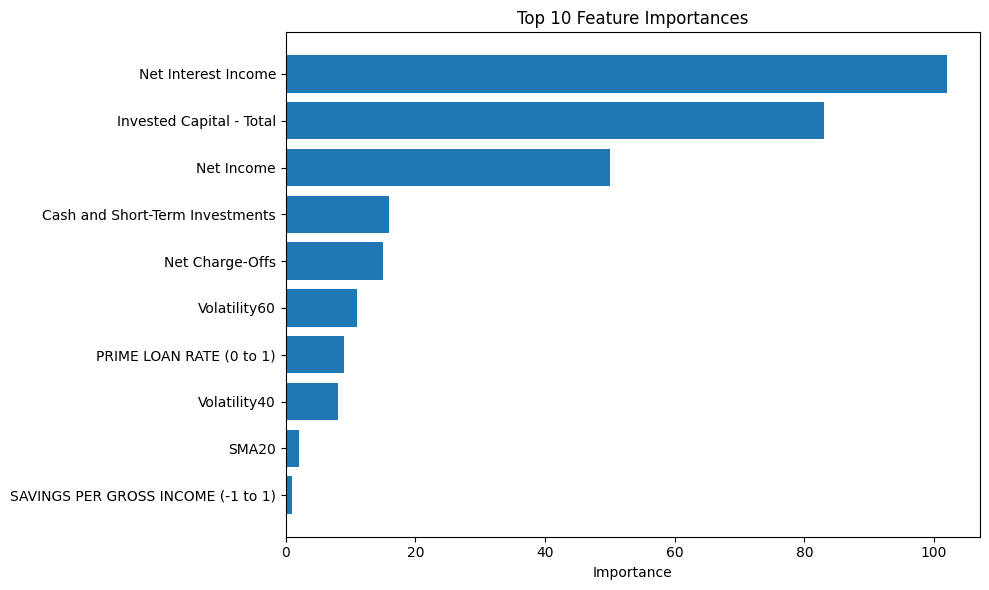

LightGBM Regression Results:
Test RMSE: 0.0739
Test MAE: 0.0536
Test R²: 0.8170


In [6]:
X_rev_train, y_rev_train, X_rev_test, y_rev_test = getting_training_dataset(df_train_rev, df_test_rev, experiment_2_rev + experiment_3_rev + experiment_4_rev + experiment_5_rev)
train_lightgbm(X_rev_train, y_rev_train, X_rev_test, y_rev_test, experiment_2_rev + experiment_3_rev + experiment_4_rev + experiment_5_rev)

Just fundamentals and lagged fundametals
Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10}


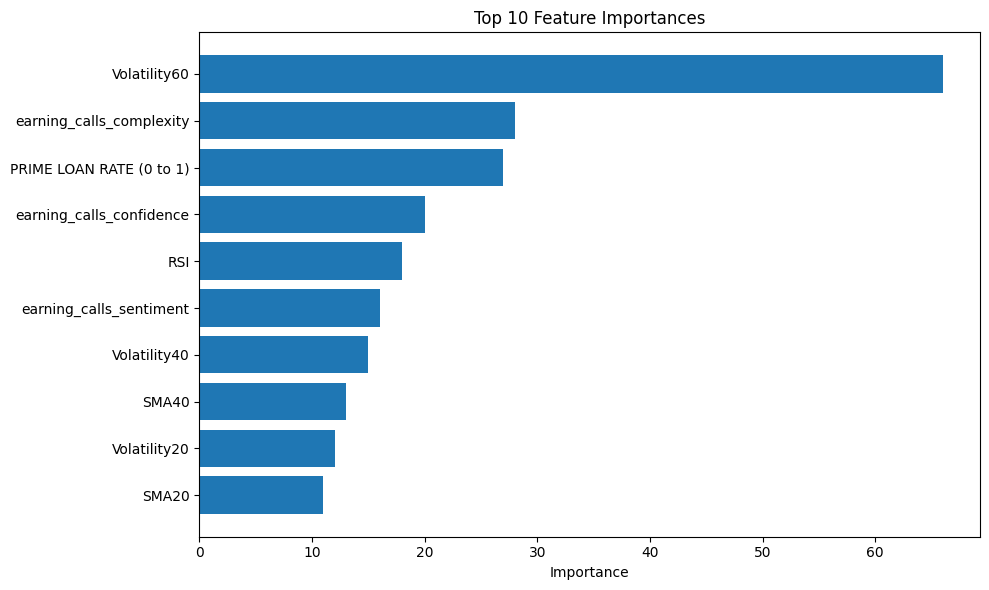

LightGBM Regression Results:
Test RMSE: 0.1368
Test MAE: 0.0966
Test R²: 0.3717


In [7]:
print("Just fundamentals and lagged fundametals")
X_rev_train, y_rev_train, X_rev_test, y_rev_test = getting_training_dataset(df_train_rev, df_test_rev, experiment_3_rev + experiment_4_rev + experiment_5_rev)
train_lightgbm(X_rev_train, y_rev_train, X_rev_test, y_rev_test, experiment_3_rev + experiment_4_rev + experiment_5_rev)

Just lagged revenue and economics stuff
Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10}


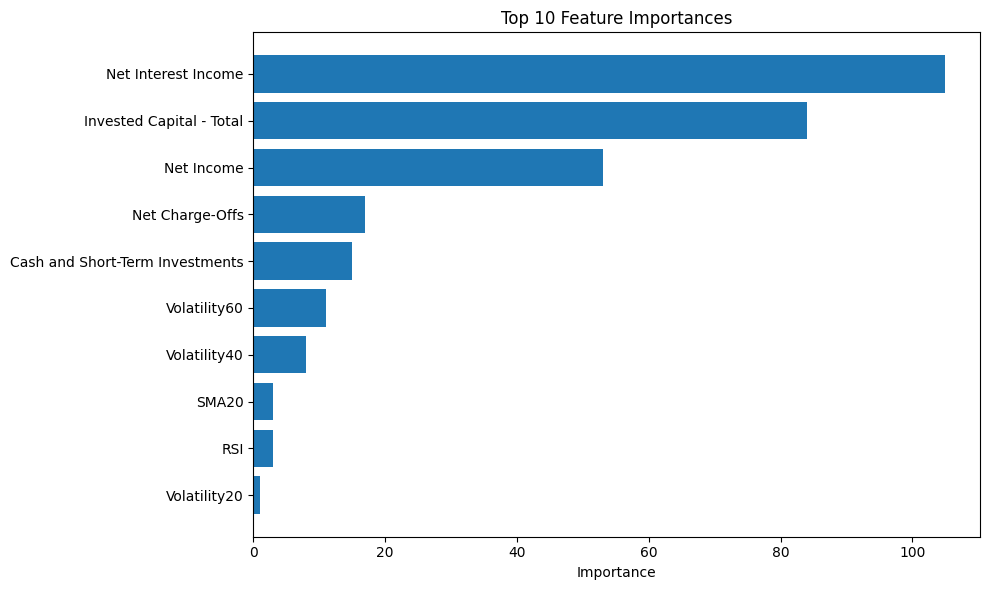

LightGBM Regression Results:
Test RMSE: 0.0743
Test MAE: 0.0541
Test R²: 0.8146


In [8]:
print("Just lagged revenue and economics stuff")
X_rev_train, y_rev_train, X_rev_test, y_rev_test = getting_training_dataset(df_train_rev, df_test_rev, experiment_2_rev + experiment_4_rev + experiment_5_rev)
train_lightgbm(X_rev_train, y_rev_train, X_rev_test, y_rev_test, experiment_2_rev + experiment_4_rev + experiment_5_rev)

Just lagged revenue and market stuff
Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10}


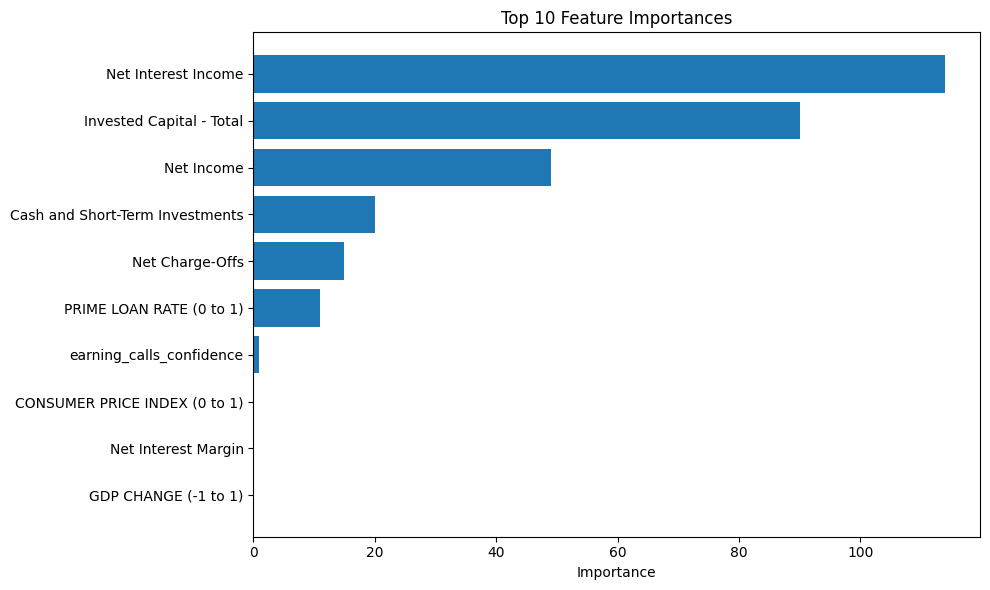

LightGBM Regression Results:
Test RMSE: 0.0742
Test MAE: 0.0541
Test R²: 0.8152


In [9]:
print("Just lagged revenue and market stuff")
X_rev_train, y_rev_train, X_rev_test, y_rev_test = getting_training_dataset(df_train_rev, df_test_rev, experiment_2_rev + experiment_3_rev + experiment_5_rev)
train_lightgbm(X_rev_train, y_rev_train, X_rev_test, y_rev_test, experiment_2_rev + experiment_3_rev + experiment_5_rev)

text sentiments
Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10}


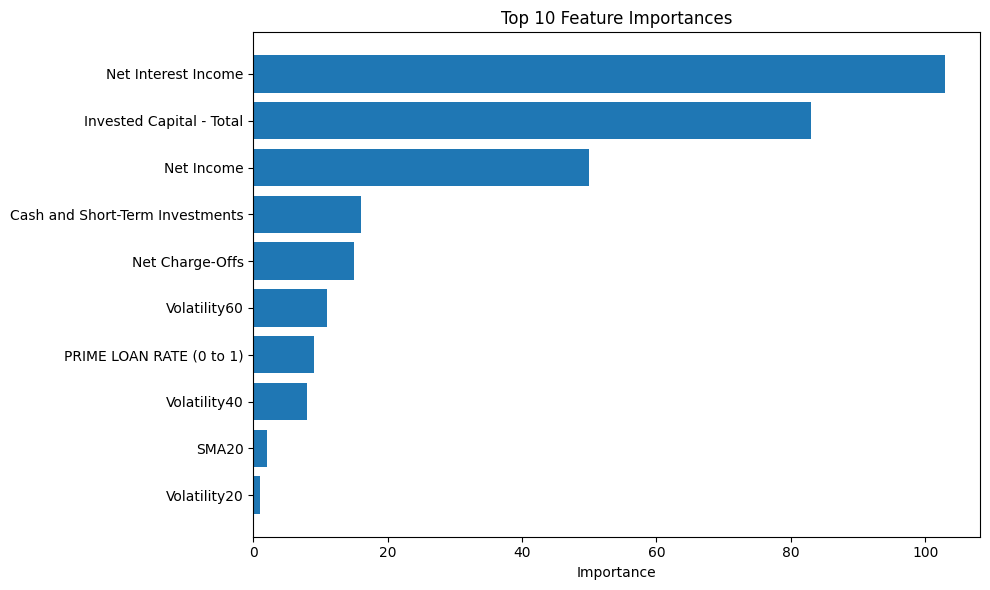

LightGBM Regression Results:
Test RMSE: 0.0739
Test MAE: 0.0536
Test R²: 0.8170


In [10]:
print("text sentiments")
X_rev_train, y_rev_train, X_rev_test, y_rev_test = getting_training_dataset(df_train_rev, df_test_rev, experiment_2_rev + experiment_3_rev + experiment_4_rev)
train_lightgbm(X_rev_train, y_rev_train, X_rev_test, y_rev_test, experiment_2_rev + experiment_3_rev + experiment_4_rev)

## CAR

In [11]:
df_train_car = pd.read_csv("data/train_data_CAR5_with_text.csv")
df_test_car = pd.read_csv("data/test_data_CAR5_with_text.csv")
df_train_car = df_train_car.sort_values(by=['tic', 'datacqtr']).reset_index(drop=True)
df_test_car = df_test_car.sort_values(by=['tic', 'datacqtr']).reset_index(drop=True)

In [12]:
df_train_car = df_train_car.dropna()
df_test_car = df_test_car.dropna()

In [13]:
# Features subset

# 1. Just lagged car

experiment_1_car = []

# 2. Just fundamental

experiment_2_car = [
    'Net Interest Income',
    'Net Interest Margin', 'Net Charge-Offs',
    'Cash and Short-Term Investments', 'Net Income',
    'Invested Capital - Total', 'Total Current Operating Revenue',
]

# 3. Just economics stuff

experiment_3_car = [
    'GDP CHANGE (-1 to 1)', 'UNEMPLOYMENT RATE (0 to 1)',
    'PRIME LOAN RATE (0 to 1)', 'DEPOSITS CHANGE (-1 to 1)',
    'CONSUMER PRICE INDEX (0 to 1)', 'SAVINGS PER GROSS INCOME (-1 to 1)'
]

# 4. Just market stuff

experiment_4_car = [
    'S&P_SMA5', 'S&P_SMA20', 'S&P_SMA50', 'S&P_RSI', 'VIX', 'SMA5', 'SMA20',
    'SMA50', 'RSI', 'Volatility5', 'Volatility20', 'Volatility50',
]

# 5. Just text sentiments

experiment_5_car = [
    'earning_calls_sentiment', 'earning_calls_confidence',
    'earning_calls_complexity', 'news_sentiment', 'news_confidence',
    'news_complexity_score', 'reviews_rating',
    'text_blob_reviews_sentiment', 'vader_reviews_sentiment_neg',
    'vader_reviews_sentiment_pos', 'bert_reviews_label',
    'bert_reviews_score',
]

Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10}


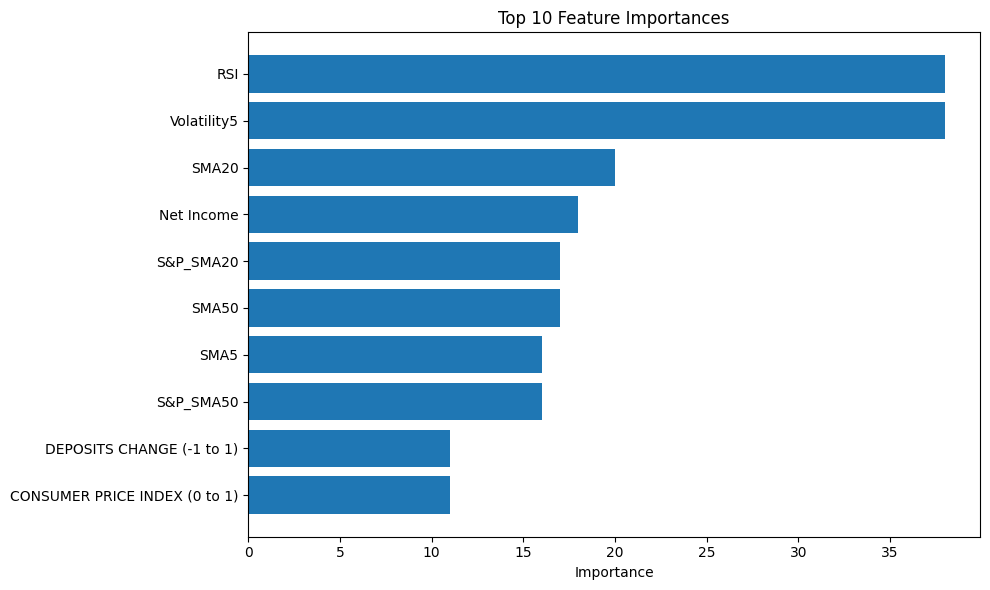

LightGBM Regression Results:
Test RMSE: 0.0589
Test MAE: 0.0444
Test R²: 0.0291


In [14]:
X_car_train, y_car_train, X_car_test, y_car_test = getting_training_dataset(df_train_car, df_test_car, experiment_2_car + experiment_3_car + experiment_4_car + experiment_5_car, "car5")
train_lightgbm(X_car_train, y_car_train, X_car_test, y_car_test, experiment_2_car + experiment_3_car + experiment_4_car + experiment_5_car,)

Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10}


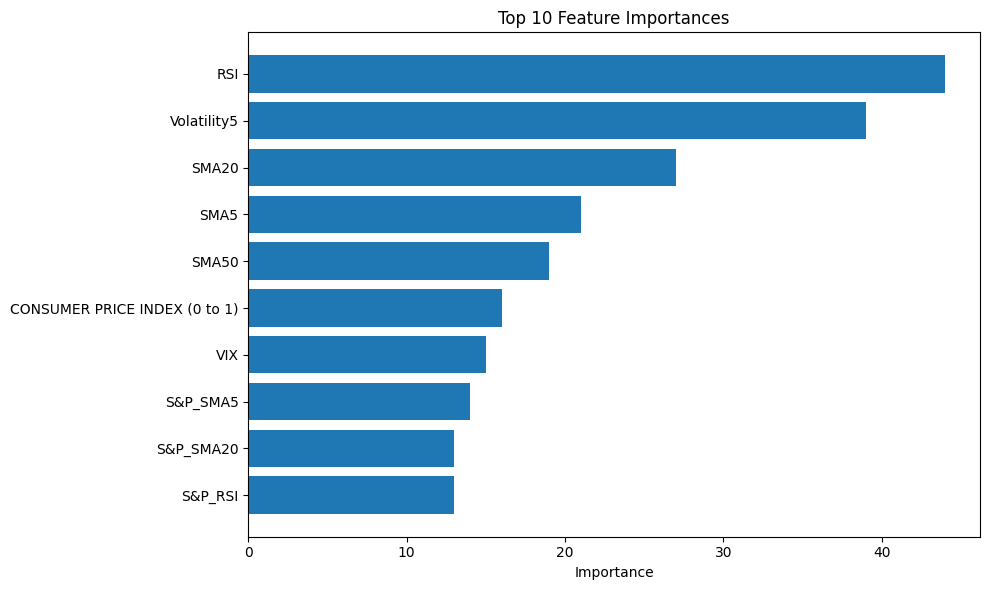

LightGBM Regression Results:
Test RMSE: 0.0591
Test MAE: 0.0443
Test R²: 0.0255


In [15]:
X_car_train, y_car_train, X_car_test, y_car_test = getting_training_dataset(df_train_car, df_test_car, experiment_3_car + experiment_4_car + experiment_5_car, "car5")
train_lightgbm(X_car_train, y_car_train, X_car_test, y_car_test, experiment_3_car + experiment_4_car + experiment_5_car,)

Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10}


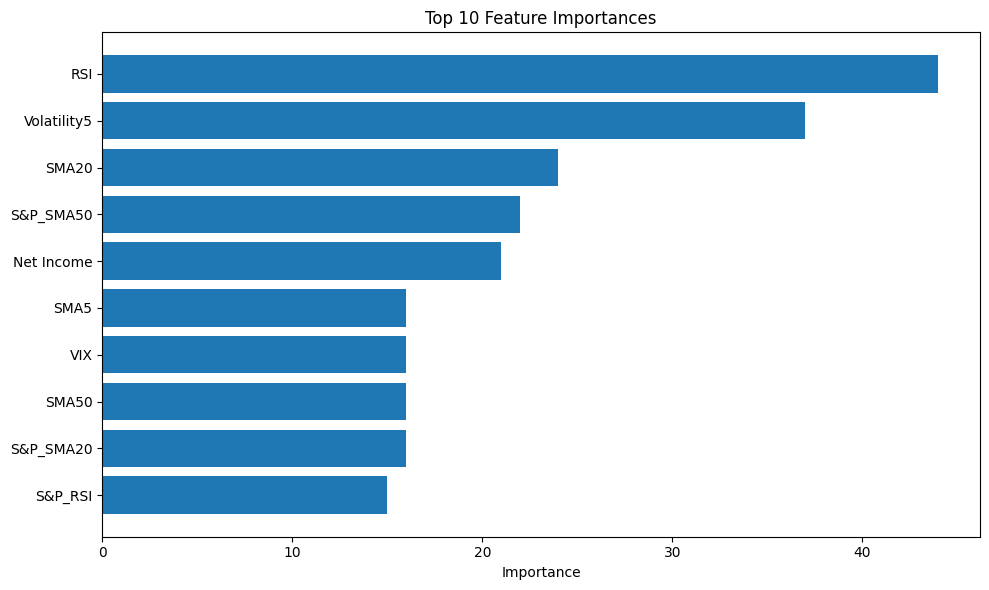

LightGBM Regression Results:
Test RMSE: 0.0582
Test MAE: 0.0438
Test R²: 0.0540


In [16]:
X_car_train, y_car_train, X_car_test, y_car_test = getting_training_dataset(df_train_car, df_test_car, experiment_2_car + experiment_4_car + experiment_5_car, "car5")
train_lightgbm(X_car_train, y_car_train, X_car_test, y_car_test, experiment_2_car + experiment_4_car + experiment_5_car,)

Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10}


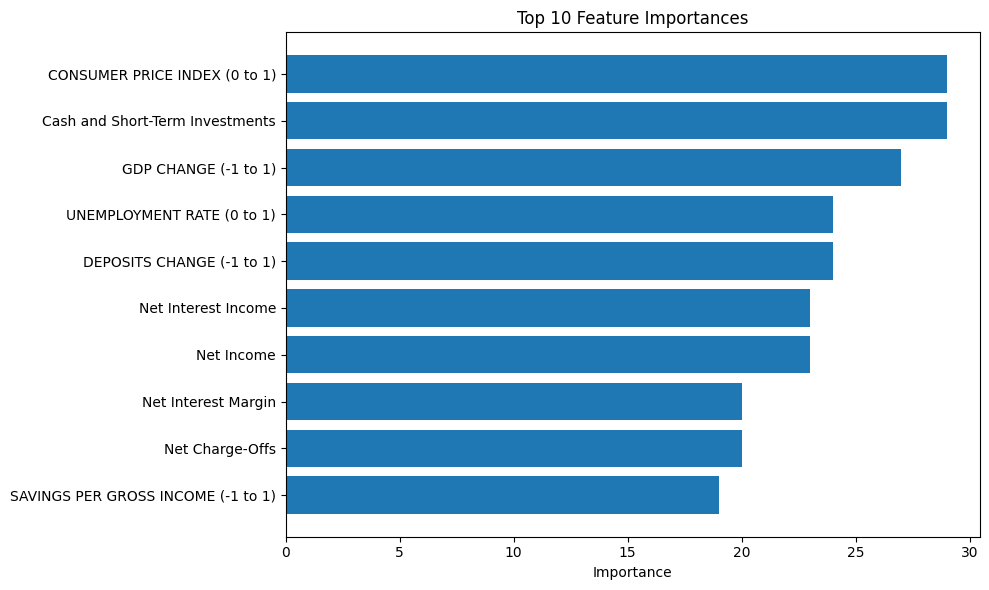

LightGBM Regression Results:
Test RMSE: 0.0614
Test MAE: 0.0462
Test R²: -0.0552


In [17]:
X_car_train, y_car_train, X_car_test, y_car_test = getting_training_dataset(df_train_car, df_test_car, experiment_2_car + experiment_3_car + experiment_5_car, "car5")
train_lightgbm(X_car_train, y_car_train, X_car_test, y_car_test, experiment_2_car + experiment_3_car + experiment_5_car)

Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10}


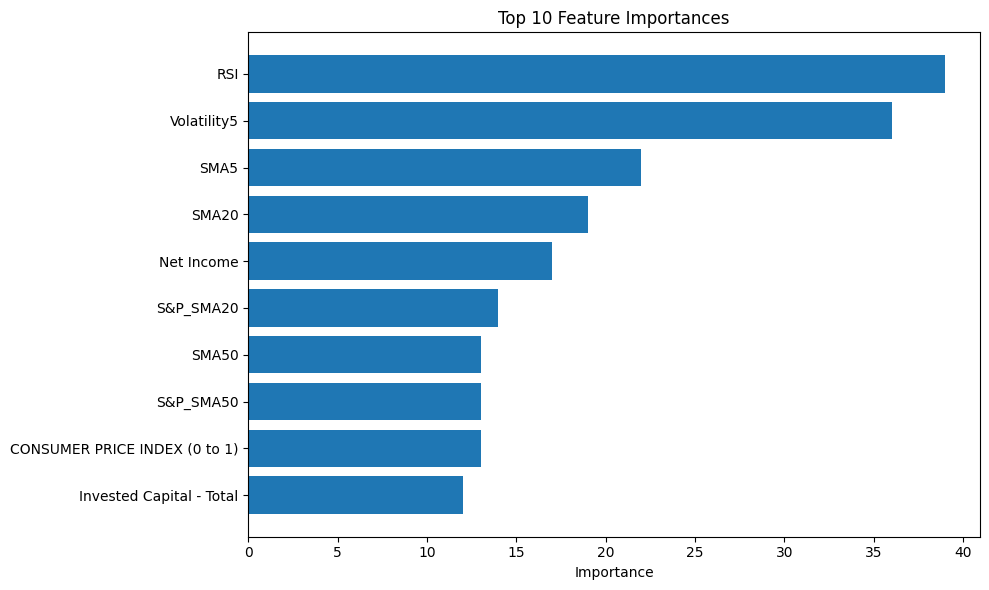

LightGBM Regression Results:
Test RMSE: 0.0591
Test MAE: 0.0444
Test R²: 0.0237


In [18]:
X_car_train, y_car_train, X_car_test, y_car_test = getting_training_dataset(df_train_car, df_test_car, experiment_2_car + experiment_3_car + experiment_4_car, "car5")
train_lightgbm(X_car_train, y_car_train, X_car_test, y_car_test, experiment_2_car + experiment_3_car + experiment_4_car)